# CNN on the simpsons

We have images of two of the simpsons children. The goal is to classify the images, using CNN. 

# 0. Loading packages

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage
#importeer Tensorflow namespaces
import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation
from keras.optimizers import SGD
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.callbacks import EarlyStopping
from keras import backend as K
from keras.utils import np_utils
from keras.preprocessing import image
#K.set_image_dim_ordering('tf')

# 1. Reading in data

1. Get list of all the images and the labels in the dataset
2. Convert the labels to numbers using labelEncoder
3. Read in the images
    + resize to shape (100,100,3)
4. Split in train and test
5. One-hot-encode the outcome

1. Get list of all the images in the dataset

Change the directory to match the path to where you stored the files on your pc.

In [2]:
directory = "./train_images/"
labels = pd.read_csv("train.csv")
label = labels["labels"].tolist()
images = labels["image"].tolist()

width = 125
height = 125

print(label[0], images[0])

healthy 800113bb65efe69e.jpg


2. Convert the labels to numbers using labelEncoder

In [3]:
from keras.utils.np_utils import to_categorical

le = preprocessing.LabelEncoder()
le.fit(np.array(label).reshape(-1,))
y_encoded = le.transform(np.array(label).reshape(-1,))
print(y_encoded)

[ 3 11  9 ...  6 10  3]


3. Read in the images

In [4]:
import cv2
X = np.zeros((len(y_encoded),width,height,3)).astype(np.float32)

for i,img in enumerate(images):
    image = io.imread("train_images/" + img)/255
    resized_image = cv2.resize(image,(width,height)).astype(np.float32)
    X[i]=resized_image

4. Split in train and test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.33, random_state=1234)

print(X_train.shape)
print(y_train.shape)

(12483, 125, 125, 3)
(12483,)


5. One-hot-encode the outcome

In [6]:
y_train_onehot = to_categorical(y_train)

y_train_onehot[0].shape

(12,)

# 1. Basic CNN model

1. Construct, compile and train a model with following layers

    Convolutional part
    
    + convolution, using 32 feature maps and a kernel size of 2x2
    + Max pooling, over, with a 2x2 pool size
    + Batch Normalization
    + convolution, using 32 feature maps and a kernel size of 2x2
    + Max pooling, over, with a 2x2 pool size
    + Batch Normalization
    
    Neural network
    
    + flatten
    + hidden layer with 10 nodes
    + output layer with how many nodes?
    + Chose the right activation functions, loss and optimizer
    + Do early stopping after 5 iterations

2. Plot the loss and validated loss over the epochs


3. What could you do to improve the accuracy? Try to think of at least three things you could do.
    + Don't actually do it. It will take too long.
    
    

1. Build, compile and train the model

In [7]:
# Architecture

input_shape=(width,height,3)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(input_shape))) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
    
model.add(Flatten()) 
model.add(Dense(50, activation='relu')) 
model.add(Dense(12, activation='softmax'))

# Compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train 
early_stopping =  EarlyStopping(patience=10)

fit1 = model.fit(X_train, y_train_onehot,batch_size=32, epochs=100,
                    validation_split=0.2,  callbacks=[early_stopping], verbose=1)


Epoch 1/100
313/313 [==============================] - 79s 247ms/step - loss: 2.0110 - accuracy: 0.3563 - val_loss: 1.7186 - val_accuracy: 0.3196
Epoch 2/100
313/313 [==============================] - 85s 270ms/step - loss: 1.4432 - accuracy: 0.4736 - val_loss: 2.0195 - val_accuracy: 0.3320
Epoch 3/100
313/313 [==============================] - 82s 263ms/step - loss: 1.1056 - accuracy: 0.5993 - val_loss: 2.3709 - val_accuracy: 0.3664
Epoch 4/100
313/313 [==============================] - 82s 261ms/step - loss: 0.7929 - accuracy: 0.7270 - val_loss: 3.9575 - val_accuracy: 0.3272
Epoch 5/100
313/313 [==============================] - 83s 266ms/step - loss: 0.5311 - accuracy: 0.8211 - val_loss: 2.4497 - val_accuracy: 0.3921
Epoch 6/100
313/313 [==============================] - 83s 264ms/step - loss: 0.3308 - accuracy: 0.8967 - val_loss: 3.4709 - val_accuracy: 0.3837
Epoch 7/100
313/313 [==============================] - 84s 268ms/step - loss: 0.2200 - accuracy: 0.9285 - val_loss: 4.7547 -

2. Plot

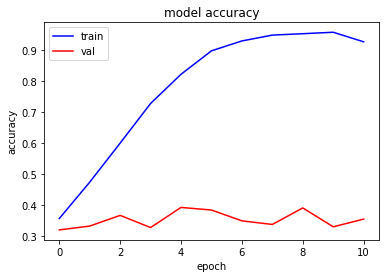

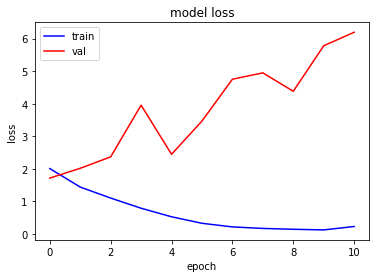

In [8]:
# Accuray 
plt.plot(fit1.history['accuracy'],'b', fit1.history['val_accuracy'],'r')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# Loss 
plt.plot(fit1.history['loss'],'b', fit1.history['val_loss'],'r')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

We ended with a accuracy of 67,25%. This is ok.  What could you do to improve it?

3. Improve

You can do different things
    + adding layers (convolutional or dense layers)
    + Increasing the nodes
    + Using image augmentation
    ...

# 2. Data augmentation
One thing you can do to improve the results, is adding more data through data augmentation.

1. Split the  trainingset into train and validation set 
    + Don't forget to one-hot-encode the outcome again
2. Build and compile the model, using the same parameters as before
3. Initiate ImageDataGenerator
4. Train the model
5. Make a plot to compare this model to the previous model (with regard to the evolution of the validated loss over the epochs).


1. Train/validation split

In [9]:
# splitting
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

# one-hot encoding
y_train2_onehot = to_categorical(y_train2)
y_val_onehot = to_categorical(y_val)

2. Build and compile the model

In [10]:
# Model
input_shape=(width,height,3)

def get_model():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(input_shape))) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Flatten()) 
    model.add(Dense(50, activation='relu')) 
    model.add(Dense(12, activation='softmax'))
    return(model)

model = get_model() 

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


3. Initiate ImageDataGenerator

In [11]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator()
 


4. Train the model

In [ ]:
early_stopping =  EarlyStopping(patience=5)
fit2_aug = model.fit_generator(aug.flow(X_train2, y_train2_onehot,batch_size=32), epochs=100,
                    steps_per_epoch=len(X_train2) // 32, callbacks=[early_stopping], verbose=1,validation_data = (X_val,y_val_onehot))



/home/jelle/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
312/312 [==============================] - ETA: 0s - loss: 1.7841 - accuracy: 0.3940

5. Compare plots

In [ ]:
plt.plot( fit1.history['val_loss'],'g', fit2_aug.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['model', 'models_with_aug'], loc='upper left')
plt.show()

This is slightly better.

# 3. Transfer learning via VGG19 

In transfer learning, you use a pre-trained model. We will use the VGG19-model. 

1. download the VGG19-model
    + Use  the correct input shape (the size of the images)
    + use include_top=False
2. Store the model as a sequential model
3. Fix the layers of the model
4. Add the top layers of the model (the neural network that will do the classification)
5. Compile and train
6. Compare to other models using the same plot as before
7. Evaluate your best model of this labo on the test-set, using the classification report

1. Download the model

In [ ]:
import tensorflow
modelVGG19 = tensorflow.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(200,200,3))
type(modelVGG19)

2. Store the model as sequential

In [ ]:
# Store as a sequential model.

model = Sequential()

for layer in modelVGG19.layers[:]:
    model.add(layer)

model.summary()

3. Fix the layers of the model

In [ ]:

for layer in model.layers:
    layer.trainable = False


4. Add the top layers of the model

In [ ]:
model.add(Flatten()) 
model.add(Dense(100, activation='relu')) 
model.add(Dense(12, activation='softmax'))

5. Compile and train the model

In [ ]:
#Compile
model.compile(loss='categorical_crossentropy',optimizer ='adam',metrics=['accuracy'])
model.summary()

# Train
batch_size = 32
early_stopping =  EarlyStopping(patience=3)
history = model.fit(X_train, y_train_onehot,batch_size=batch_size, epochs=100,
                    validation_split=0.2, callbacks=[early_stopping])



6. Compare with previous models using a plot

In [ ]:
plt.plot( fit1.history['val_loss'],'g', fit2_aug.history['val_loss'],'r', history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['model1', 'model2_aug', 'model3_transfer_learning'], loc='upper left')
plt.show()

This is the best model so far, so we choose this model and evaluate on the test set.

7. Evaluate on test set

In [ ]:
test_predict = model.predict_classes(X_test)
print(classification_report(y_test, test_predict))
